In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Step 1: Load Data and Prepare it for Pytorch 

In [2]:
train_data_path = "../input/digit-recognizer/train.csv"
train_df = pd.read_csv(train_data_path)

print(train_df.head(3))

print(train_df.shape)


   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  

[3 rows x 785 columns]
(42000, 785)


In [3]:
print(train_df.loc[:, train_df.columns != 'label'])

       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995       0       0       0       0       0       0       0       0       0   
41996       0       0       0       0       0       0       0       0       0   
41997       0       0       0       0       0       0       0       0       0   
41998       0       0       0       0       0       0       0       0       0   
41999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel77

In [4]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # reshape the input image (which is flattened array) to 2D (28x28)
        image = self.images[index].reshape(28,28)
        label = self.labels[index]
        
        # convert numpy image to PIL (pyrhon imaging lib) image (for transforms)
        # Note that the image data ranges [0,1] but it is scaled to [0, 255], which 
        # is the standard representation for grayscale pixel values: 
        # 0 black, 255 white, and values in between for varying shades of gray.
        image = Image.fromarray( (image * 255).astype('uint8'))
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(num_output_channels = 1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_images = np.array(train_df.loc[:, train_df.columns != 'label'])
train_labels = np.array( train_df['label'])

print(type(train_images), train_images.shape, train_labels.shape)

dataset = CustomDataset(train_images,train_labels, transform = transform)

# split the data
train_len = int(0.7 * len(dataset))
val_len = int(0.15 * len(dataset))
test_len = len(dataset) - train_len - val_len

print(train_len, val_len, test_len)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len] )
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

<class 'numpy.ndarray'> (42000, 784) (42000,)
29399 6300 6301


torch.Size([1, 28, 28]) 9
torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 5
torch.Size([1, 28, 28]) 6
torch.Size([1, 28, 28]) 2
torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 6
torch.Size([1, 28, 28]) 2
torch.Size([1, 28, 28]) 2


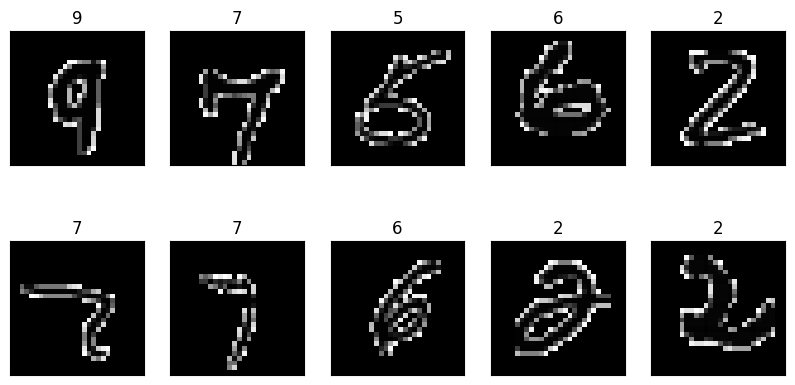

In [5]:
# Visualize some of the images
fig = plt.figure(figsize=(10, 5))
for i in range(0, 10):
    img, label = train_dataset[i*4]
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    
    # denormalize the image to display it properly.
    print(img.shape, label)
    img = img / 2 + 0.5

    ax.imshow(img[0], cmap='gray')
    ax.set_title(str(label))


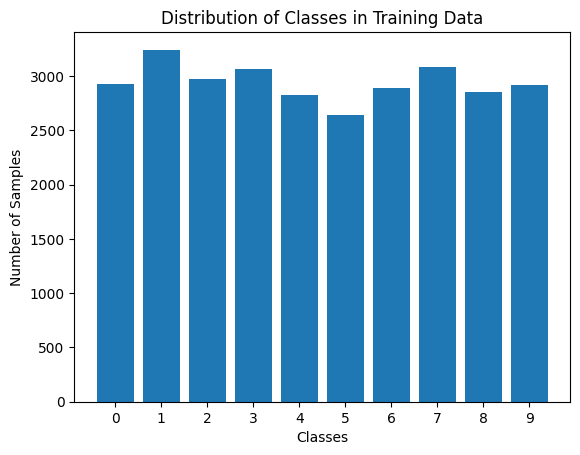

In [6]:
# check the label data
label_list = [label for img, label in train_dataset]

# importing Counter module
from collections import Counter
label_counts = Counter(label_list)

# Display as bar chart
labels, counts = zip(*label_counts.items())
plt.bar(labels, counts, tick_label=[str(i) for i in labels])
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in Training Data')
plt.show()

# Step 2 : Initialize the model

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels =1, out_channels = 32, kernel_size = 3, stride =1, padding =1)
        self.conv2 = nn.Conv2d(in_channels =32, out_channels = 64, kernel_size = 3, stride =1, padding =1)

        self.fc1 = nn.Linear(in_features = 64*7*7, out_features = 128)
        self.fc2 = nn.Linear(in_features = 128, out_features = 10)
        
        self.max_pool = nn.MaxPool2d(kernel_size =2, stride=2, padding = 0)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        #self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool(x)
        
        x = x.view(-1, 64*7*7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        #x = self.softmax(self.fc2(x))
        
        return x
    

# Model, Loss and Optimizer
model = SimpleCNN()


# Step 3 : Train the model

In [8]:

def train_model(model, train_loader, val_loader, num_epochs, lr, opt_func = torch.optim.Adam):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = opt_func(model.parameters(), lr)
    
    # Save the losses and accuracies each epoch
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0.
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            y_pred = model(X_batch)
            
            # To determine which class the model predicts for each sample based on the highest score
            _, predicted = torch.max(y_pred, 1)
        
            train_correct += (predicted == y_batch).sum().item()
            
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        
        val_loss = 0
        val_correct = 0 
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                
                _, predicted = torch.max(y_pred, 1)
                val_correct += (predicted == y_batch).sum().item()
                
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        val_accuracy = val_correct / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)
        

        print(f"Epoch {epoch+1}/{num_epochs} => "
              f"Train loss: {train_loss:.4f}, "
              f"Train accuracy: {train_accuracy:.4f}, "
              f"Validation loss: {val_loss:.4f}, "
              f"Validation accuracy: {val_accuracy:.4f}")
        
    return train_losses, train_accuracies, val_losses, val_accuracies

# Training loop
num_epochs = 12
lr = 1.e-3

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, lr)

Epoch 1/12 => Train loss: 0.7793, Train accuracy: 0.7389, Validation loss: 0.2435, Validation accuracy: 0.9268
Epoch 2/12 => Train loss: 0.3169, Train accuracy: 0.9014, Validation loss: 0.1580, Validation accuracy: 0.9516
Epoch 3/12 => Train loss: 0.2447, Train accuracy: 0.9248, Validation loss: 0.1201, Validation accuracy: 0.9624
Epoch 4/12 => Train loss: 0.2023, Train accuracy: 0.9374, Validation loss: 0.1177, Validation accuracy: 0.9640
Epoch 5/12 => Train loss: 0.1788, Train accuracy: 0.9444, Validation loss: 0.1070, Validation accuracy: 0.9668
Epoch 6/12 => Train loss: 0.1597, Train accuracy: 0.9496, Validation loss: 0.0986, Validation accuracy: 0.9690
Epoch 7/12 => Train loss: 0.1473, Train accuracy: 0.9540, Validation loss: 0.0991, Validation accuracy: 0.9697
Epoch 8/12 => Train loss: 0.1324, Train accuracy: 0.9585, Validation loss: 0.0887, Validation accuracy: 0.9708
Epoch 9/12 => Train loss: 0.1195, Train accuracy: 0.9620, Validation loss: 0.0904, Validation accuracy: 0.9710
E

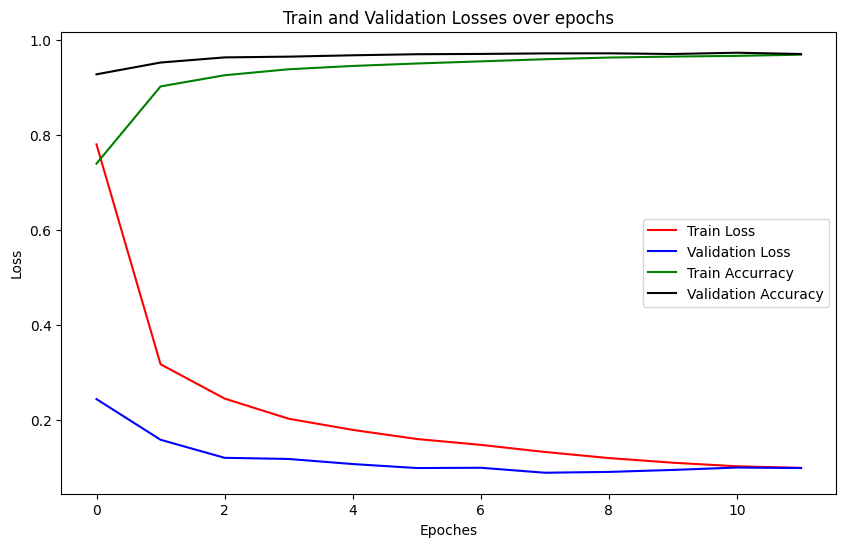

In [9]:
# plot the losses
plt.figure(figsize = (10,6))

plt.plot(range(num_epochs), train_losses, label = 'Train Loss', color = 'red')
plt.plot(range(num_epochs), val_losses, label = 'Validation Loss', color = 'blue')
plt.plot(range(num_epochs), train_accuracies, label = 'Train Accurracy', color = 'green')
plt.plot(range(num_epochs), val_accuracies, label = 'Validation Accuracy', color = 'black')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.title('Train and Validation Losses over epochs')
plt.legend()
plt.show()

In [10]:
def predict(model, dataloader):
    """
    Predict the model over a dataloader.
    
    Arguments:
    - model : The trained model
    - dataloader : DataLoader instance containing the data to predict and evaluate
    
    Returns:
    - predicted : model predictions
    - labels : actual labels
    """
    
    # Set the model to evaluation mode
    model.eval()
    predictions = []
    actual = []
    
    # No need to track gradients for validation
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            # Predict
            y_pred = model(X_batch)
            _, predicted = torch.max(y_pred, 1)
            
            predictions.extend(predicted.squeeze().tolist())
            actual.extend(y_batch.squeeze().tolist())
        
    return predictions, actual

predictions, actual_values = predict(model, test_loader)


correct = 0
total = 0

for idx, value in enumerate(actual_values):
    #print(np.array(value), np.array(predictions[idx]))
    
    # Update correct counters
    if predictions[idx] == value:
        correct += 1
    
accuracy = correct / len(actual_values)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.49%


## Final submission

In [11]:
test_data_path = "/kaggle/input/digit-recognizer/test.csv"
test_df = pd.read_csv(test_data_path)

print(test_df.head(3))

print(test_df.shape)



   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  

[3 rows x 784 columns]
(28000, 784)


In [12]:
# apply the same cleaning/preprocessing methods to the test data
test_images = np.array(test_df)

test_df['label'] = 0 
test_labels= np.array(test_df['label'])

print(test_images.shape, test_labels.shape)


test_dataset = CustomDataset(test_images,test_labels, transform = transform)

test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

predictions, _ = predict(model, test_loader) # actual data is not unused 



(28000, 784) (28000,)


In [13]:
print(len(predictions))
# prepare the submission
submit_df = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
#submit_df.to_csv('/kaggle/working/submission.csv',index=False)
print(submit_df.head())


submit_df['Label'] = predictions

submit_df.to_csv('/kaggle/working/submission.csv',index=False)
print(submit_df.head())


28000
   ImageId  Label
0        1      0
1        2      0
2        3      0
3        4      0
4        5      0
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
